In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


In [21]:
bike_hourly = pd.read_csv('hourly_weather.csv')

**Data Wrangling** 

In [22]:
#create a copy of the bike hourly data
bike_hourly_new = bike_hourly.copy()

In [23]:
bike_hourly_new.isnull().sum()

Casual                     11
Date                        0
Hour                        0
Member                     11
Total_rides                11
relativehumidity_2m (%)     0
temperature_2m (°C)         0
weathercode (wmo code)      0
windspeed_10m (km/h)        0
dtype: int64

In [24]:
# Convert the 'Date' column to datetime
bike_hourly_new['Date'] = pd.to_datetime(bike_hourly_new['Date'])

# Ensure 'Hour' is integer (if it's not already)
bike_hourly_new['Hour'] = bike_hourly_new['Hour'].astype(int)

# Convert float columns correctly
float_columns = ['Casual', 'Member', 'Total_rides', 'temperature_2m (°C)', 'windspeed_10m (km/h)']
bike_hourly_new[float_columns] = bike_hourly_new[float_columns].astype(float)

# Convert integer columns
int_columns = ['relativehumidity_2m (%)', 'weathercode (wmo code)']
bike_hourly_new[int_columns] = bike_hourly_new[int_columns].astype(int)

#adding month_year as a column
bike_hourly_new['month_year'] = bike_hourly_new['Date'].dt.strftime('%Y-%m')

#convert month year to datetime
bike_hourly_new['month_year'] = pd.to_datetime(bike_hourly_new['month_year'])

#have a year column
bike_hourly_new['year'] = bike_hourly_new['Date'].dt.year

# Check the updated data types
print(bike_hourly_new.dtypes)


Casual                            float64
Date                       datetime64[ns]
Hour                                int64
Member                            float64
Total_rides                       float64
relativehumidity_2m (%)             int64
temperature_2m (°C)               float64
weathercode (wmo code)              int64
windspeed_10m (km/h)              float64
month_year                 datetime64[ns]
year                                int32
dtype: object


In [25]:
#change the columns to lowercase and remove spaces
bike_hourly_new.columns = bike_hourly_new.columns.str.lower().str.replace(' ', '_')
bike_hourly_new.head()

,casual,date,hour,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year
0,20.0,2021-01-01,0,26.0,46.0,90,2.4,1,10.2,2021-01-01,2021
1,23.0,2021-01-01,1,23.0,46.0,88,1.8,1,10.0,2021-01-01,2021
2,20.0,2021-01-01,2,28.0,48.0,87,1.1,2,10.1,2021-01-01,2021
3,9.0,2021-01-01,3,7.0,16.0,81,1.6,2,10.6,2021-01-01,2021
4,7.0,2021-01-01,4,5.0,12.0,77,1.6,2,9.9,2021-01-01,2021


**Feature Enginnering**

In [26]:
#adding holiday as a column
cal = calendar()
holidays = cal.holidays(start=bike_hourly_new['date'].min(), end=bike_hourly_new['date'].max())
bike_hourly_new['holiday'] = bike_hourly_new['date'].isin(holidays)

#add month and day of the week as columns
bike_hourly_new['month'] = bike_hourly_new['date'].dt.month
bike_hourly_new['day_of_week'] = bike_hourly_new['date'].dt.dayofweek

#adding season as a column
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

bike_hourly_new['season'] = bike_hourly_new['date'].dt.month.apply(get_season)

#adding holiday as a column
cal = calendar()
holidays = cal.holidays(start=bike_hourly_new['date'].min(), end=bike_hourly_new['date'].max())
bike_hourly_new['holiday'] = bike_hourly_new['date'].isin(holidays)

#change season to a category
bike_hourly_new['season'] = bike_hourly_new['season'].astype('category')

#adding month_year as a column
bike_hourly_new['month_year'] = pd.to_datetime(bike_hourly_new['date']).dt.to_period('M')



In [27]:
#change data type from integer to category for day of the week
bike_hourly_new['day_of_week'] = bike_hourly_new['day_of_week'].astype('category')

#change data type from integer to category for month
bike_hourly_new['month'] = bike_hourly_new['month'].astype('category')

#change the day of the week to actual names
bike_hourly_new['day_of_week'] = bike_hourly_new['day_of_week'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

#change the month to actual names
bike_hourly_new['month'] = bike_hourly_new['month'].map({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})

#change the holiday column to yes or no
bike_hourly_new['holiday'] = bike_hourly_new['holiday'].map({True: 'Yes', False: 'No'})

#change the hour to a early morning, morning, afternoon, evening, or night
def get_time_of_day(hour):
    if hour in [0, 1, 2, 3, 4, 5]:
        return 'Early Morning'
    elif hour in [6, 7, 8, 9, 10, 11]:
        return 'Morning'
    elif hour in [12, 13, 14, 15, 16, 17]:
        return 'Afternoon'
    elif hour in [18, 19, 20, 21, 22, 23]:
        return 'Evening'
    
bike_hourly_new['time_of_day'] = bike_hourly_new['hour'].apply(get_time_of_day)



# Define bin edges and labels based on WMO weather codes
bins = [0, 4, 20, 40, 50, 60, 70, 80, 90, 100]
labels = [
    "Clear/Cloudy", 
    "Atmospheric Obstructions", 
    "Fog Conditions", 
    "Drizzle", 
    "Rain", 
    "Snow", 
    "Showers", 
    "Thunderstorms",
    "Extreme Weather"
]

# Define humidity bins and labels
humidity_bins = [0, 30, 60, 80, 100]
humidity_labels = ['Low', 'Moderate', 'High', 'Very High']

# Define windspeed bins and labels
windspeed_bins = [0, 5, 20, 39, 61, float('inf')]
windspeed_labels = ['Calm', 'Light Breeze', 'Moderate Breeze', 'Strong Breeze', 'High Wind']

# Ensure the columns are numeric before processing
bike_hourly_new['relativehumidity_2m_(%)'] = pd.to_numeric(bike_hourly_new['relativehumidity_2m_(%)'], errors='coerce')
bike_hourly_new['windspeed_10m_(km/h)'] = pd.to_numeric(bike_hourly_new['windspeed_10m_(km/h)'], errors='coerce')
bike_hourly_new['weathercode_(wmo_code)'] = pd.to_numeric(bike_hourly_new['weathercode_(wmo_code)'], errors='coerce')

# Apply binning to relevant columns
bike_hourly_new['weather_category'] = pd.cut(
    bike_hourly_new['weathercode_(wmo_code)'], 
    bins=bins, 
    labels=labels, 
    right=False, 
    include_lowest=True
)

bike_hourly_new['humidity_category'] = pd.cut(
    bike_hourly_new['relativehumidity_2m_(%)'], 
    bins=humidity_bins, 
    labels=humidity_labels, 
    right=True, 
    include_lowest=True
)

bike_hourly_new['windspeed_category'] = pd.cut(
    bike_hourly_new['windspeed_10m_(km/h)'], 
    bins=windspeed_bins, 
    labels=windspeed_labels, 
    right=True, 
    include_lowest=True
)

# Display results
print(bike_hourly_new[['windspeed_10m_(km/h)', 'windspeed_category']].head())

# Display results
print(bike_hourly_new[['relativehumidity_2m_(%)', 'humidity_category']].head())



   windspeed_10m_(km/h) windspeed_category
0                  10.2       Light Breeze
1                  10.0       Light Breeze
2                  10.1       Light Breeze
3                  10.6       Light Breeze
4                   9.9       Light Breeze
   relativehumidity_2m_(%) humidity_category
0                       90         Very High
1                       88         Very High
2                       87         Very High
3                       81         Very High
4                       77              High


In [28]:
bike_hourly_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   casual                   26269 non-null  float64       
 1   date                     26280 non-null  datetime64[ns]
 2   hour                     26280 non-null  int64         
 3   member                   26269 non-null  float64       
 4   total_rides              26269 non-null  float64       
 5   relativehumidity_2m_(%)  26280 non-null  int64         
 6   temperature_2m_(°c)      26280 non-null  float64       
 7   weathercode_(wmo_code)   26280 non-null  int64         
 8   windspeed_10m_(km/h)     26280 non-null  float64       
 9   month_year               26280 non-null  period[M]     
 10  year                     26280 non-null  int32         
 11  holiday                  26280 non-null  object        
 12  month                    26280 n

In [29]:
#idenifying the null values 
bike_hourly_new.isnull().sum()

#find the null values in the dataset
bike_hourly_new[bike_hourly_new.isnull().any(axis=1)]


,casual,date,hour,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year,holiday,month,day_of_week,season,time_of_day,weather_category,humidity_category,windspeed_category
21853,NaN,2021-01-21,3,NaN,NaN,73,-3.1,0,5.1,2021-01,2021,No,January,Thursday,Winter,Early Morning,Clear/Cloudy,High,Light Breeze
21854,NaN,2021-01-22,3,NaN,NaN,71,0.4,0,11.2,2021-01,2021,No,January,Friday,Winter,Early Morning,Clear/Cloudy,High,Light Breeze
21855,NaN,2021-02-02,3,NaN,NaN,86,0.3,71,19.8,2021-02,2021,No,February,Tuesday,Winter,Early Morning,Showers,Very High,Light Breeze
21856,NaN,2021-02-03,2,NaN,NaN,71,-1.2,3,20.6,2021-02,2021,No,February,Wednesday,Winter,Early Morning,Clear/Cloudy,High,Moderate Breeze
21857,NaN,2021-02-09,1,NaN,NaN,82,-4.0,1,7.8,2021-02,2021,No,February,Tuesday,Winter,Early Morning,Clear/Cloudy,Very High,Light Breeze
21858,NaN,2021-02-19,2,NaN,NaN,94,-1.1,71,10.9,2021-02,2021,No,February,Friday,Winter,Early Morning,Showers,Very High,Light Breeze
21859,NaN,2021-02-19,3,NaN,NaN,93,-1.6,51,10.4,2021-02,2021,No,February,Friday,Winter,Early Morning,Rain,Very High,Light Breeze
21860,NaN,2021-03-14,2,NaN,NaN,56,2.9,0,13.9,2021-03,2021,No,March,Sunday,Spring,Early Morning,Clear/Cloudy,Moderate,Light Breeze
21861,NaN,2022-01-04,2,NaN,NaN,77,-8.7,0,10.1,2022-01,2022,No,January,Tuesday,Winter,Early Morning,Clear/Cloudy,High,Light Breeze
21862,NaN,2022-03-13,2,NaN,NaN,50,-5.1,0,21.1,2022-03,2022,No,March,Sunday,Spring,Early Morning,Clear/Cloudy,Moderate,Moderate Breeze


In [30]:
#find the null values in the dataset grouped by the hour
bike_hourly_new[bike_hourly_new.isnull().any(axis=1)].groupby('hour').count()


,casual,date,member,total_rides,relativehumidity_2m_(%),temperature_2m_(°c),weathercode_(wmo_code),windspeed_10m_(km/h),month_year,year,holiday,month,day_of_week,season,time_of_day,weather_category,humidity_category,windspeed_category
hour,,,,,,,,,,,,,,,,,,
1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,6,0,0,6,6,6,6,6,6,6,6,6,6,6,6,6,6
3,0,4,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [31]:
#value_counts all categorical columns
print(bike_hourly_new['season'].value_counts())
print(bike_hourly_new['holiday'].value_counts())
print(bike_hourly_new['day_of_week'].value_counts())
print(bike_hourly_new['month'].value_counts())
print(bike_hourly_new['weather_category'].value_counts())
print(bike_hourly_new['humidity_category'].value_counts())
print(bike_hourly_new['windspeed_category'].value_counts())


season
Spring    6624
Summer    6624
Fall      6552
Winter    6480
Name: count, dtype: int64
holiday
No     25488
Yes      792
Name: count, dtype: int64
day_of_week
Friday       3768
Saturday     3768
Sunday       3768
Monday       3744
Tuesday      3744
Wednesday    3744
Thursday     3744
Name: count, dtype: int64
month
January      2232
March        2232
May          2232
July         2232
August       2232
October      2232
December     2232
April        2160
June         2160
September    2160
November     2160
February     2016
Name: count, dtype: int64
weather_category
Clear/Cloudy                23231
Rain                         2190
Snow                          639
Showers                       220
Atmospheric Obstructions        0
Fog Conditions                  0
Drizzle                         0
Thunderstorms                   0
Extreme Weather                 0
Name: count, dtype: int64
humidity_category
Moderate     9568
Very High    7272
High         7070
Low          2

In [32]:
#creating a group by statical summary for hour and total rides
hourly_summary = bike_hourly_new.groupby('hour')['total_rides'].describe()
hourly_summary



,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,1095.0,108.292237,93.769060,3.0,46.0,76.0,137.5,557.0
1,1094.0,67.658135,74.546780,2.0,20.0,36.0,81.0,535.0
2,1089.0,42.972452,51.515713,1.0,12.0,20.0,49.0,375.0
3,1091.0,23.287809,24.899792,1.0,8.0,14.0,26.0,183.0
4,1095.0,19.990868,9.177804,1.0,13.0,19.0,26.0,74.0
5,1095.0,54.244749,28.649946,2.0,31.0,52.0,77.0,123.0
6,1095.0,154.711416,89.387295,5.0,76.0,148.0,218.0,508.0
7,1095.0,343.016438,219.799072,8.0,153.0,321.0,502.5,971.0
8,1095.0,577.359817,369.982531,13.0,272.0,511.0,833.5,1654.0


In [33]:
#filling the null values with the mean of the column for casual and member and total rides and windspeed
bike_hourly_new['casual'] = bike_hourly_new['casual'].fillna(bike_hourly_new['casual'].mean())
bike_hourly_new['member'] = bike_hourly_new['member'].fillna(bike_hourly_new['member'].mean())
bike_hourly_new['total_rides'] = bike_hourly_new['total_rides'].fillna(bike_hourly_new['total_rides'].mean())



In [34]:
bike_hourly_new.isnull().sum()

casual                     0
date                       0
hour                       0
member                     0
total_rides                0
relativehumidity_2m_(%)    0
temperature_2m_(°c)        0
weathercode_(wmo_code)     0
windspeed_10m_(km/h)       0
month_year                 0
year                       0
holiday                    0
month                      0
day_of_week                0
season                     0
time_of_day                0
weather_category           0
humidity_category          0
windspeed_category         0
dtype: int64

**EDA**

In [35]:
#creating the statistical summary of the dataset
bike_hourly_new[['casual', 'member', 'total_rides', 'temperature_2m_(°c)', 'windspeed_10m_(km/h)', 'relativehumidity_2m_(%)']].describe()

,casual,member,total_rides,temperature_2m_(°c),windspeed_10m_(km/h),relativehumidity_2m_(%)
count,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,159.930070,247.165632,407.095702,14.412782,10.171298,62.967884
std,167.295402,225.236384,372.927334,10.285751,5.261033,22.724320
min,0.000000,0.000000,1.000000,-14.600000,0.000000,5.000000
25%,28.000000,55.000000,85.000000,6.100000,6.500000,46.000000
50%,105.000000,204.000000,319.000000,14.800000,9.200000,64.000000
75%,236.000000,371.000000,616.000000,22.700000,12.900000,82.000000
max,1206.000000,1534.000000,2262.000000,41.500000,40.100000,100.000000


**Understanding Groupby and Aggregation**

In [46]:
#grouping the data of total rides, casual, and member by year in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('year', observed=False)[['casual', 'member']].sum() / bike_hourly_new[['casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by holidays in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('holiday', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

# Group data by 'season' and calculate percentage, rounding to 2 decimal places
print(bike_hourly_new.groupby('season', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by time of day in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('time_of_day', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by month in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('month', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by day of the week in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('day_of_week', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))  

#grouping the data of total rides, casual, and member by weather category in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('weather_category', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by humidity category in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('humidity_category', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))

#grouping the data of total rides, casual, and member by windspeed category in percentage and rounding to 2 decimal places
print(bike_hourly_new.groupby('windspeed_category', observed=False)[['total_rides', 'casual', 'member']].sum() / bike_hourly_new[['total_rides', 'casual', 'member']].sum().round(2))


        casual    member
year                    
2021  0.265963  0.251759
2022  0.340711  0.314925
2023  0.393325  0.433316
         total_rides    casual    member
holiday                                 
No          0.973331  0.968077  0.976731
Yes         0.026669  0.031923  0.023269
        total_rides    casual    member
season                                 
Fall       0.295223  0.272772  0.309751
Spring     0.247929  0.266250  0.236073
Summer     0.316683  0.350448  0.294834
Winter     0.140166  0.110530  0.159342
               total_rides    casual    member
time_of_day                                   
Afternoon         0.430729  0.467072  0.407213
Early Morning     0.032768  0.036582  0.030300
Evening           0.279876  0.277539  0.281389
Morning           0.256627  0.218807  0.281098
           total_rides    casual    member
month                                     
January       0.038789  0.030266  0.044305
February      0.041263  0.031836  0.047362
March         0.0

**Corelation Matrix**

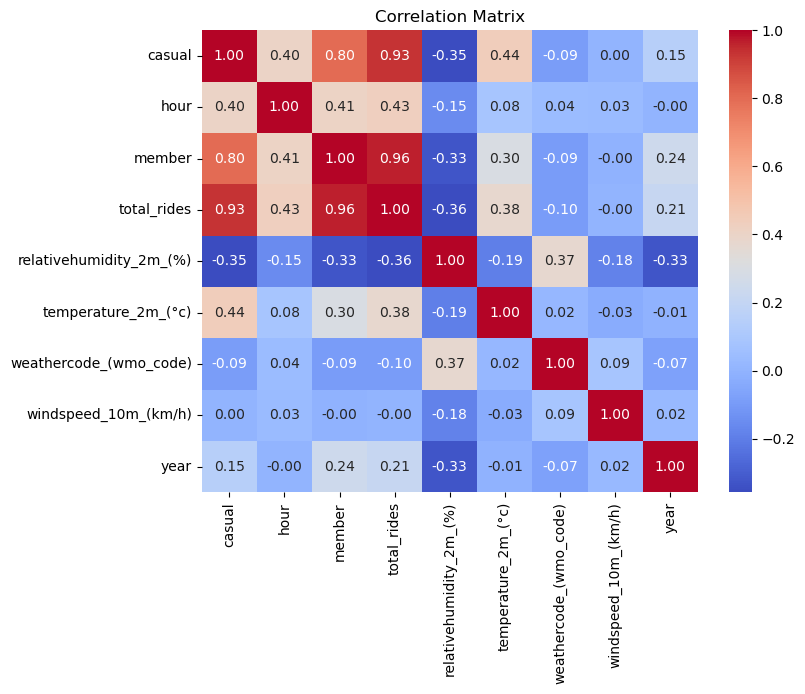

In [37]:
#selecting only the columns that are numeric for the correlation matrix
numeric_columns = bike_hourly_new.select_dtypes(include=[np.number]).columns

#creating a correlation matrix
correlation_matrix = bike_hourly_new[numeric_columns].corr()

#generating a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

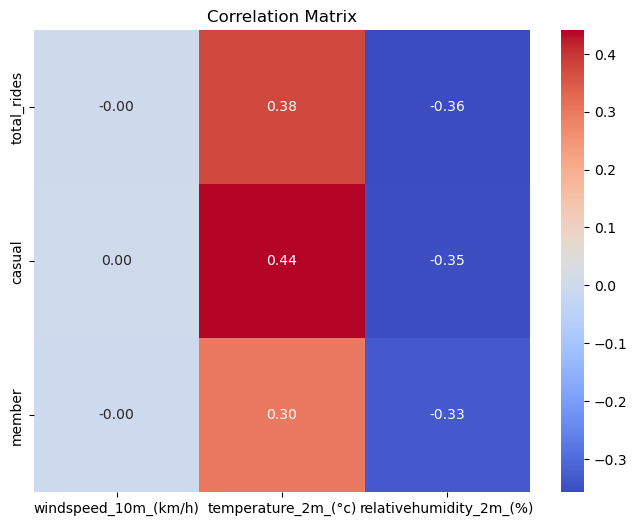

In [38]:
#numerical columns that are related to total rides, casual, and member
numeric_columns = ['casual', 'member', 'total_rides', 'temperature_2m_(°c)', 'relativehumidity_2m_(%)', 'windspeed_10m_(km/h)']
correlation_matrix = bike_hourly_new[numeric_columns].corr()

#extract the correlation of total rides with casual and member
correlation_total_rides = correlation_matrix.loc[['total_rides','casual','member'],['windspeed_10m_(km/h)', 'temperature_2m_(°c)', 'relativehumidity_2m_(%)']]
correlation_total_rides

#generating a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_total_rides, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**Visualization**

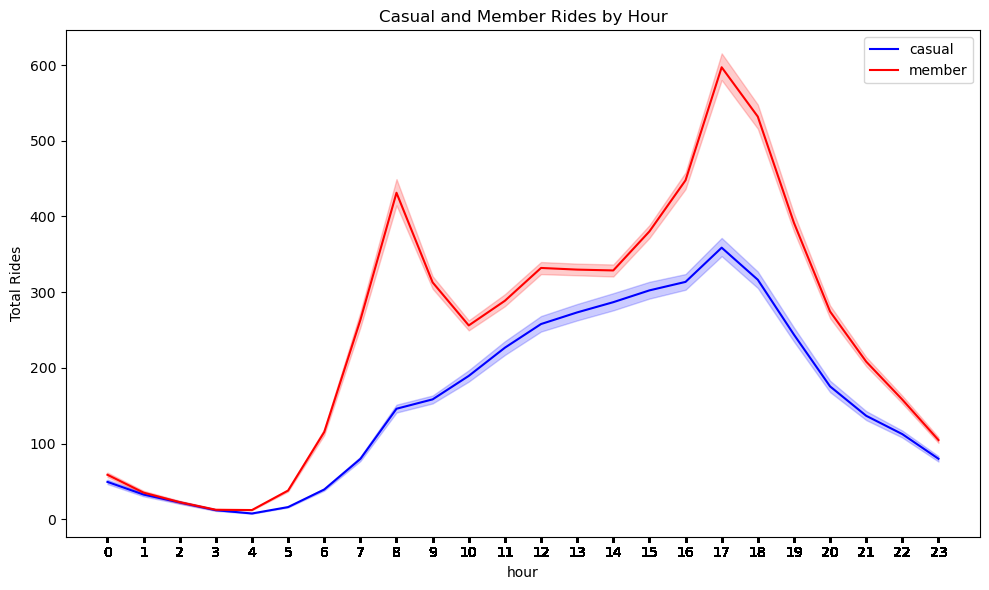

In [39]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='casual', data=bike_hourly_new, label='casual',color='blue')
sns.lineplot(x='hour', y='member', data=bike_hourly_new, label='member',color='red')


# Show all hour values on the x-axis
plt.xticks(ticks=bike_hourly_new['hour'])  # Show all hours explicitly

plt.title('Casual and Member Rides by Hour')
plt.ylabel('Total Rides')
plt.tight_layout()
plt.show()

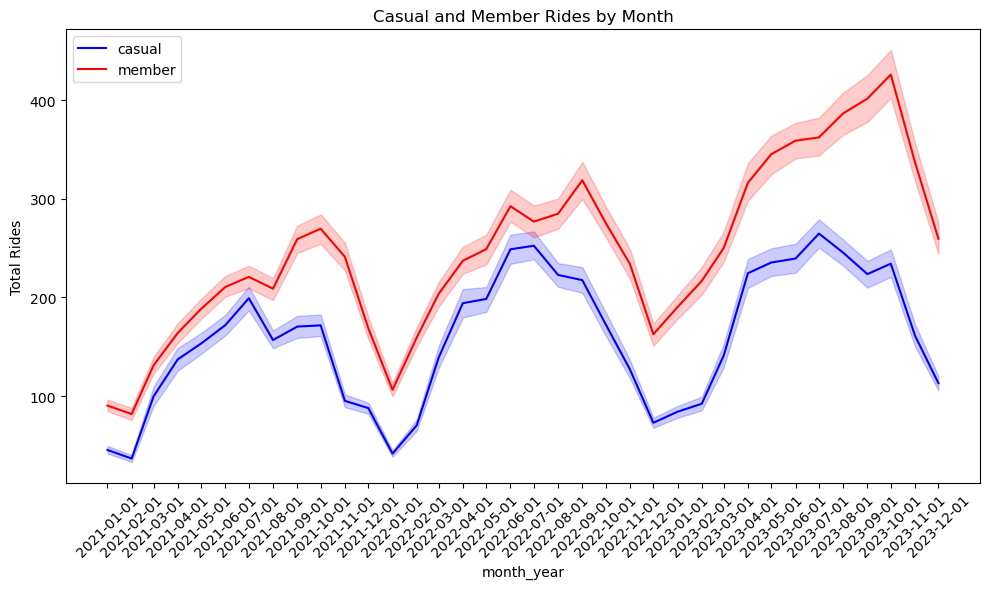

In [40]:
# Convert 'month_year' to datetime for plotting
bike_hourly_new['month_year'] = bike_hourly_new['month_year'].dt.to_timestamp()

plt.figure(figsize=(10, 6))
sns.lineplot(x='month_year', y='casual', data=bike_hourly_new, label='casual', color='blue')
sns.lineplot(x='month_year', y='member', data=bike_hourly_new, label='member', color='red')
plt.xticks(rotation=45)
plt.xticks(ticks=bike_hourly_new['month_year'].unique())  # Show all months explicitly
plt.title('Casual and Member Rides by Month')
plt.ylabel('Total Rides')
plt.tight_layout()
plt.show()

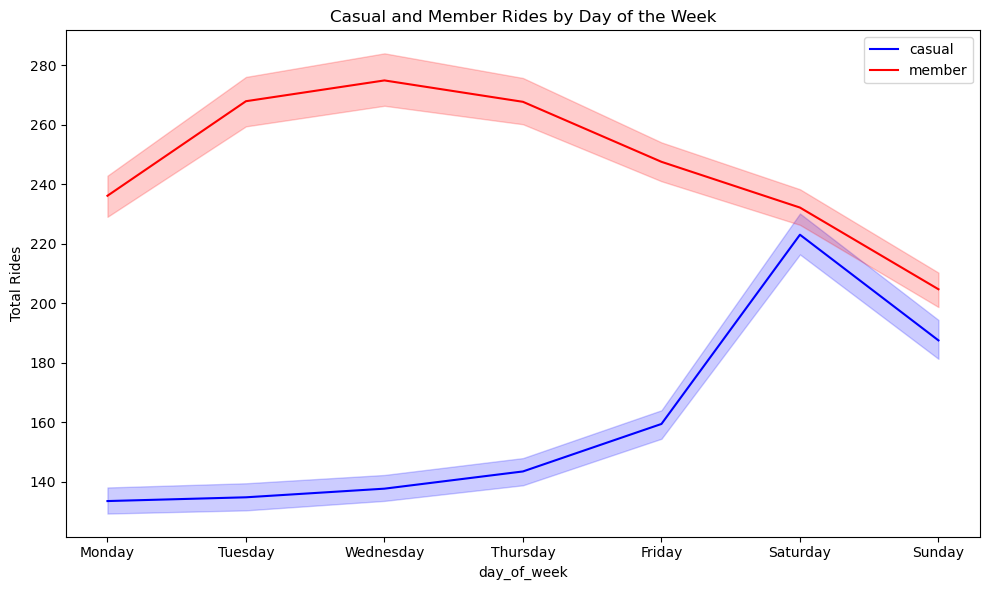

In [41]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='day_of_week', y='casual', data=bike_hourly_new, label='casual', color='blue')
sns.lineplot(x='day_of_week', y='member', data=bike_hourly_new, label='member', color='red')
plt.title('Casual and Member Rides by Day of the Week')
plt.ylabel('Total Rides')
plt.tight_layout()
plt.show()


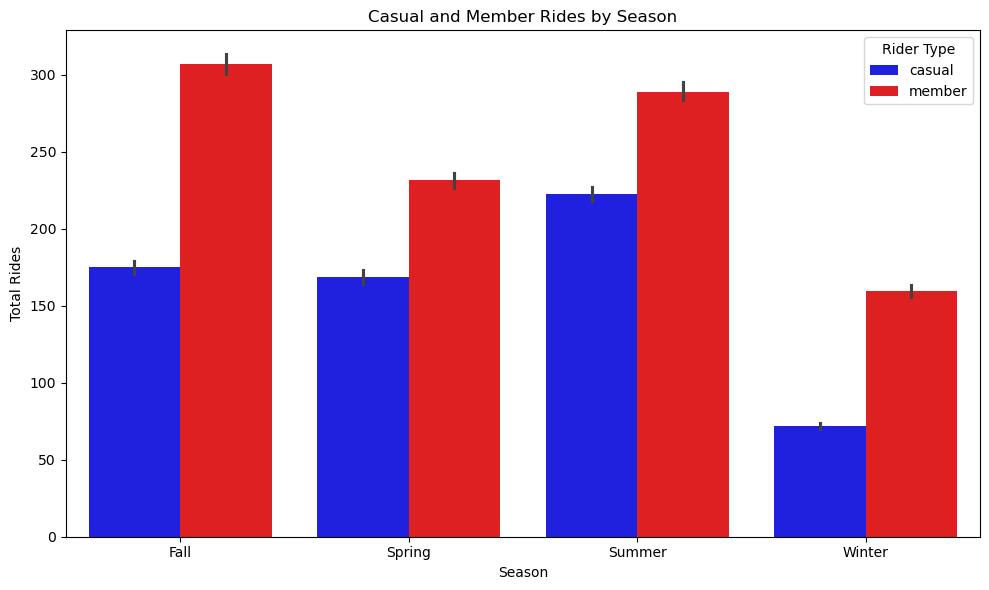

In [42]:
# Reshape the DataFrame for Seaborn (long format)
bike_melted = bike_hourly_new.melt(id_vars=['season'], value_vars=['casual', 'member'],var_name='Rider Type', value_name='Total Rides')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='Total Rides', hue='Rider Type', data=bike_melted, palette=['blue', 'red'])

# Customize the plot
plt.title('Casual and Member Rides by Season')
plt.xlabel('Season')
plt.ylabel('Total Rides')
plt.tight_layout()

# Show the plot
plt.show()

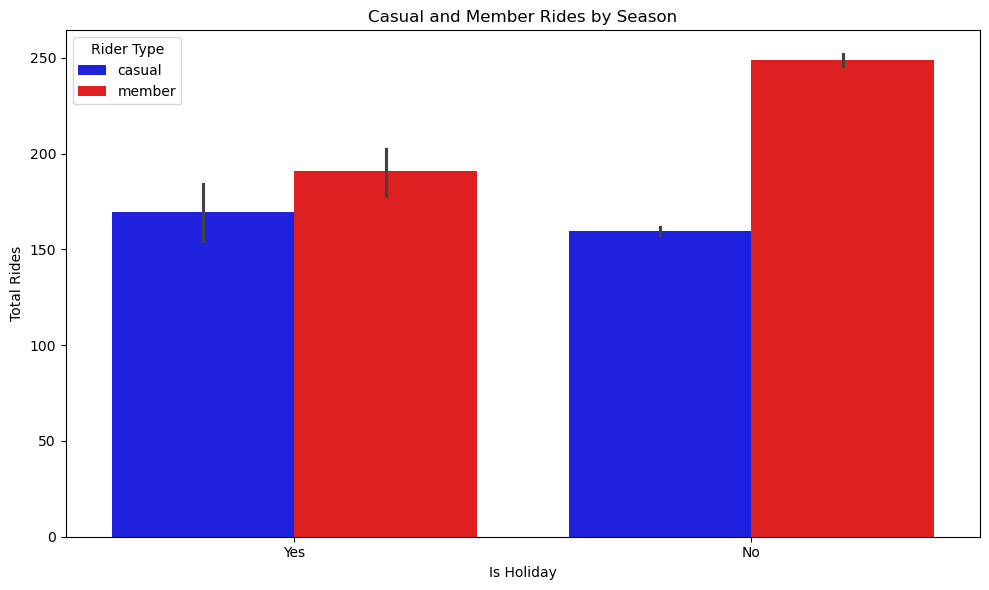

In [43]:
# Reshape the DataFrame for Seaborn (long format)
bike_melted = bike_hourly_new.melt(id_vars=['holiday'], value_vars=['casual', 'member'],var_name='Rider Type', value_name='Total Rides')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='holiday', y='Total Rides', hue='Rider Type', data=bike_melted, palette=['blue', 'red'])

# Customize the plot
plt.title('Casual and Member Rides by Season')
plt.xlabel('Is Holiday')
plt.ylabel('Total Rides')
plt.tight_layout()

# Show the plot
plt.show()

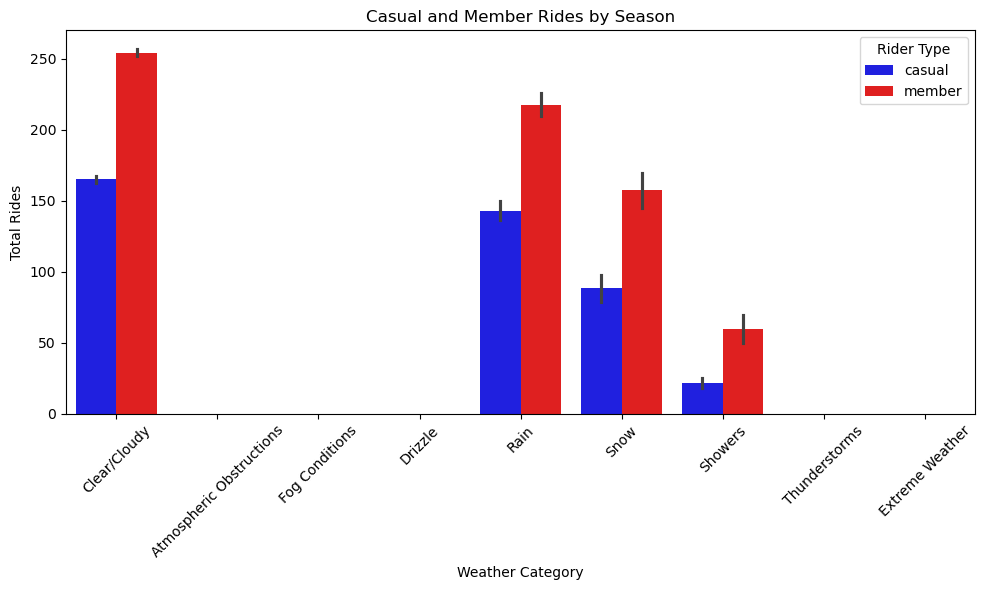

In [44]:
# Reshape the DataFrame for Seaborn (long format)
bike_melted = bike_hourly_new.melt(id_vars=['weather_category'], value_vars=['casual', 'member'],var_name='Rider Type', value_name='Total Rides')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='weather_category', y='Total Rides', hue='Rider Type', data=bike_melted, palette=['blue', 'red'])

# Customize the plot
plt.title('Casual and Member Rides by Season')
plt.xlabel('Weather Category')
plt.xticks(rotation=45)
plt.ylabel('Total Rides')
plt.tight_layout()

# Show the plot
plt.show()

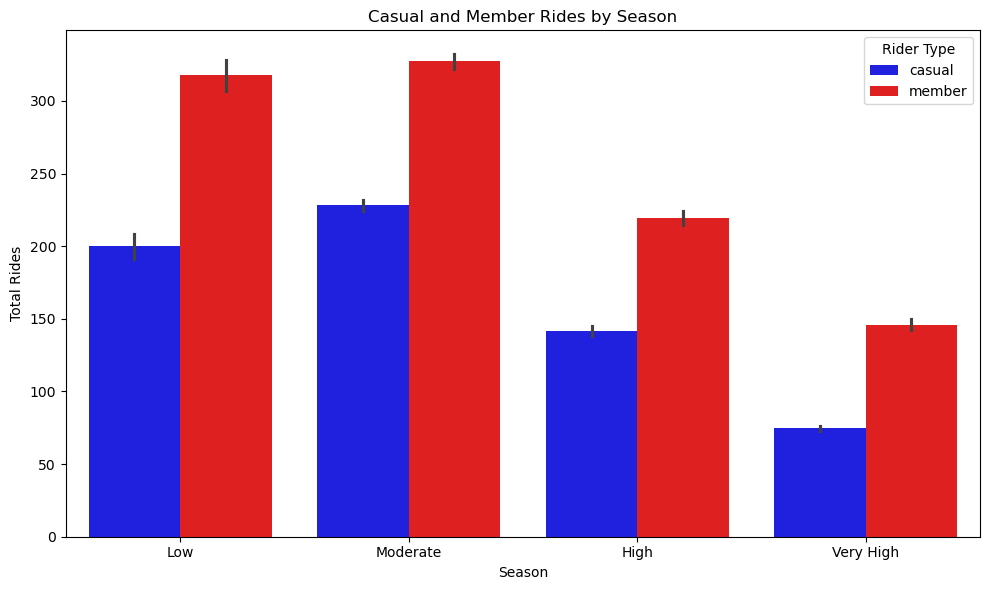

In [45]:
# Reshape the DataFrame for Seaborn (long format)
bike_melted = bike_hourly_new.melt(id_vars=['humidity_category'], value_vars=['casual', 'member'],var_name='Rider Type', value_name='Total Rides')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='humidity_category', y='Total Rides', hue='Rider Type', data=bike_melted, palette=['blue', 'red'])

# Customize the plot
plt.title('Casual and Member Rides by Season')
plt.xlabel('Season')
plt.ylabel('Total Rides')
plt.tight_layout()

# Show the plot
plt.show()

# Convert datetime to numerical values for regression
bike_hourly_new['month_year_numeric'] = bike_hourly_new['month_year'].astype('int64') // 10**9  # Convert to seconds

# Perform linear regression for 'casual'
casual_fit = np.polyfit(bike_hourly_new['month_year_numeric'], bike_hourly_new['casual'], 1)
casual_trend = np.poly1d(casual_fit)

# Perform linear regression for 'member'
member_fit = np.polyfit(bike_hourly_new['month_year_numeric'], bike_hourly_new['member'], 1)
member_trend = np.poly1d(member_fit)

plt.figure(figsize=(10, 6))

# Original data
sns.lineplot(x='month_year', y='casual', data=bike_hourly_new, label='Casual', color='blue')
sns.lineplot(x='month_year', y='member', data=bike_hourly_new, label='Member', color='red')

# Plot linear trend lines
plt.plot(bike_hourly_new['month_year'], casual_trend(bike_hourly_new['month_year_numeric']), label='Casual Trend', color='blue', linestyle='--')
plt.plot(bike_hourly_new['month_year'], member_trend(bike_hourly_new['month_year_numeric']), label='Member Trend', color='red', linestyle='--')

plt.xticks(rotation=45)
plt.xticks(ticks=bike_hourly_new['month_year'].unique())  # Show all months explicitly
plt.title('Casual and Member Rides by Month with Linear Trend Lines')
plt.ylabel('Total Rides')
plt.legend()
plt.tight_layout()
plt.show()